### Understanding Player Behavior Through Gameplay Time, Ratings, and Sentiment

**Team:** Group 11 

- Yicong Li 
- Member 2  
- Member 3  
- Member 4  


# ---------------------------------------------------------
### Introduction
In this project, we chose the **Video Game Industry** as the theme for data cleaning and integration.  
The reasons for selecting this topic are as follows:

- The video game industry is one of the fastest-growing global cultural and technological sectors.  
  Its data—such as sales volume, player preferences, and game genres—shows clear trends and strong research value.

- The data sources are abundant and easy to access, making them suitable for cross-platform data integration.  
  For example, large platforms such as **Kaggle** and **Steam** provide extensive public game information with clear patterns in ratings, player behaviour, and game types.

- Game datasets often contain issues such as missing values, inconsistent formats, duplicate entries, mixed categories, and     natural-language challenges within player reviews. This makes them highly suitable for practicing comprehensive data cleaning   and preprocessing.

Therefore, in this project, we use two datasets provided by **Kaggle**, and through cleaning, field alignment, and merging processes, we construct a final **analysis-ready dataset** for our research tasks.

# ---------------------------------------------------------

### Task 1

# ---------------------------------------------------------
Wrangling Steps — Data Import Stage

This section of the code performs the following tasks:
1. Import the required Python libraries for later analysis (e.g., pandas, numpy)
2. Specify the file paths
3. Load the two external datasets (vgsales.csv / hltb.jsonlines)
4. Apply dataset-specific cleaning procedures (e.g., handling NA, missing values, removing unnecessary columns) to prepare them for analysis
5. Merge both datasets into the final combined dataset, which includes the following columns:  
   gameName, genre, reviewScore, playTime
# ---------------------------------------------------------

In [1]:
## loading needed packages
import pandas as pd
import numpy as np
import re

**Task 1: dataset 1 (vgslaes.csv) - load & clean**

In [2]:
## data path
data_path = './dataset/'

## mandatory dataset （dataset 1）
## This dataset we want to get game name and genre for further analysis
vgsales = pd.read_csv(data_path + "vgsales.csv") 
vgsales

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


- Import only the required columns (game name, genre) 

In [3]:
vgsales = vgsales[["Name", "Genre"]].copy()
vgsales_unique = vgsales.drop_duplicates(subset=["Name"], keep="first").reset_index(drop=True)
vgsales_unique

,Name,Genre
0,Wii Sports,Sports
1,Super Mario Bros.,Platform
2,Mario Kart Wii,Racing
3,Wii Sports Resort,Sports
4,Pokemon Red/Pokemon Blue,Role-Playing
...,...,...
11488,Chou Ezaru wa Akai Hana: Koi wa Tsuki ni Shiru...,Action
11489,Eiyuu Densetsu: Sora no Kiseki Material Collec...,Role-Playing
11490,Plushees,Simulation
11491,Woody Woodpecker in Crazy Castle 5,Platform


Task 1: dataset 2 (hltb.jsonlines) - load & clean

In [5]:
## dataset 2 (hltb.jsonlines)
hltb = pd.read_json(data_path + "hltb.jsonlines", lines=True)
hltb.head()

,Name,Stats,steam_app_id,Release_date,Genres,Review_score
0,Borderlands 3,{'Additional Content': {'Moxxi's Heist of the ...,397540.0,2019-09-13,"First-Person, Action, Shooter",76
1,Dying Light,{'Additional Content': {'The Following': {'Pol...,239140.0,2015-01-27,"Action, Adventure, Open World, Survival Horror",78
2,Middle-Earth: Shadow of War,{'Additional Content': {'Blade of Galadriel': ...,356190.0,2017-10-10,"Action, Adventure",76
3,Counter-Strike: Global Offensive,"{'Multi-Player': {'Co-Op': {'Polled': '34', 'A...",730.0,2012-08-21,"First-Person, Shooter",74
4,Grand Theft Auto IV,{'Additional Content': {'The Lost and Damned':...,5152.0,2008-04-29,"Third-Person, Action, Sandbox, Shooter",82


- Extracting and Normalizing Platform Playtime Data (define a function)

In [6]:
## the 'stats' column contains the average playtime for each platform,
## we need to extract the playtime values for every platform as reference data 
## for further analysis.
## The code below keeps only entries where 'platform' data is non-empty;
## rows with empty or zero-value platform data will be filtered out.

def normalize_stats(stats):
    # If the value is not a dict (e.g., NaN / None) → return an empty dict
    if not isinstance(stats, dict):
        return {}
    
    # Case 1: 'Platform' wraps another level:
    # {'Platform': {'PC': {...}, 'PS4': {...}}}
    if "Platform" in stats:
        inner = stats["Platform"]
        return inner if isinstance(inner, dict) else {}
    
    # Case 2: No 'Platform' key — already in the format:
    # {'PC': {...}, 'PS4': {...}}
    return stats

hltb["Stats"] = hltb["Stats"].apply(normalize_stats)
mask = hltb["Stats"].apply(lambda x: isinstance(x, dict) and len(x) > 0)
hltb = hltb[mask].reset_index(drop=True)

## check how the stats looks like
hltb['Stats'][0]

{'Google Stadia': {'Polled': '12',
  'Main': '28h 40m',
  'Main +': '65h 40m',
  '100%': '133h 1m',
  'Fastest': '25h',
  'Slowest': '158h'},
 'PC': {'Polled': '926',
  'Main': '22h 57m',
  'Main +': '46h 14m',
  '100%': '83h 11m',
  'Fastest': '11h 6m',
  'Slowest': '498h'},
 'PlayStation 4': {'Polled': '248',
  'Main': '23h 52m',
  'Main +': '46h 5m',
  '100%': '65h 39m',
  'Fastest': '11h 17m',
  'Slowest': '250h'},
 'PlayStation 5': {'Polled': '50',
  'Main': '25h 32m',
  'Main +': '46h 18m',
  '100%': '61h 13m',
  'Fastest': '17h 28m',
  'Slowest': '113h'},
 'Xbox One': {'Polled': '116',
  'Main': '23h 44m',
  'Main +': '51h 58m',
  '100%': '73h 22m',
  'Fastest': '12h 3m',
  'Slowest': '413h'},
 'Xbox Series X/S': {'Polled': '28',
  'Main': '22h 47m',
  'Main +': '56h 48m',
  '100%': '124h 1m',
  'Fastest': '14h 12m',
  'Slowest': '172h'}}

- Defining the Target Platforms (list)

In [7]:
## We extract the list of platform names involved in our dataset 
## (these correspond to the platform-specific average playtime values)

target_platforms = [
    "PC",
    "PlayStation 2",
    "PlayStation 3",
    "PlayStation 4",
    "PlayStation 5",
    "Xbox One",
    "Xbox 360",
    "Xbox Series X/S",
    "Super Nintendo",
    "Wii",
    "Wii U"
]

- Converting Playtime Strings into Numeric Hours (function)

In [8]:
### Convert extracted playtime strings into numeric hour values
### e.g. original value "12h 30m"  →  converted to 12.5
### e.g. original value "None"     →  converted to NaN
### The goal is to unify formatting and make later calculations easier.

def parse_hour_string(s):
    if not isinstance(s, str):
        return np.nan
    
    h = re.search(r"(\d+)h", s)
    m = re.search(r"(\d+)m", s)

    hours = int(h.group(1)) if h else 0
    mins = int(m.group(1)) if m else 0
    
    return round(hours + mins/60, 2)


- Extracting Main Story Playtime for Each Platform

In [9]:
## From the Stats column, extract the “Main” (main story playtime) value 
## for each platform in target_platforms. 
## The extracted playtime strings will then be converted into standardized 
## numeric hour values for analysis.

def extract_main_plus(stats):
    result = {}
    for p in target_platforms:
        if p in stats and isinstance(stats[p], dict):
            main_plus = stats[p].get("Main")
            result[p] = parse_hour_string(main_plus)
        else:
            result[p] = np.nan
    return result

platform_df = hltb["Stats"].apply(extract_main_plus).apply(pd.Series)


- Merging Cleaned Platform Playtime Data Back Into the Main Dataset

In [10]:
## Merge the cleaned platform-level playtime data (platform_df)
## back into the original hltb dataset to construct the final dataset.
## Then remove the original Stats column, since it is no longer needed.

hltb_final = pd.concat([hltb, platform_df], axis=1)
del hltb_final['Stats']

In [11]:
## check how our dataset looks like now !!!
hltb_final 

,Name,steam_app_id,Release_date,Genres,Review_score,PC,PlayStation 2,PlayStation 3,PlayStation 4,PlayStation 5,Xbox One,Xbox 360,Xbox Series X/S,Super Nintendo,Wii,Wii U
0,Borderlands 3,397540.0,2019-09-13,"First-Person, Action, Shooter",76,22.95,NaN,NaN,23.87,25.53,23.73,NaN,22.78,NaN,NaN,NaN
1,Dying Light,239140.0,2015-01-27,"Action, Adventure, Open World, Survival Horror",78,17.98,NaN,NaN,19.20,24.98,17.08,NaN,17.58,NaN,NaN,NaN
2,Middle-Earth: Shadow of War,356190.0,2017-10-10,"Action, Adventure",76,20.90,NaN,NaN,20.60,15.93,20.77,NaN,23.50,NaN,NaN,NaN
3,Counter-Strike: Global Offensive,730.0,2012-08-21,"First-Person, Shooter",74,59.85,NaN,60.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Grand Theft Auto IV,5152.0,2008-04-29,"Third-Person, Action, Sandbox, Shooter",82,27.13,NaN,28.65,NaN,NaN,25.77,29.13,23.98,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35702,PlatONIR,882070.0,2018-07-04,Platform,10,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35703,Life Beetle,527480.0,2017-04-18,,33,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35704,Apocalypse: Party's Over,368800.0,2016-05-30,"Side, Scrolling, Action",0,4.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35705,10mg :),1425380.0,2020-10-15,"Side, Top-Down, Real-Time, Arcade, Pinball, Pu...",78,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Converting Platform Columns to Numeric Values and Computing Total Playtime

In [12]:

# Keep only the platform columns that actually exist in the DataFrame
# (this prevents errors in case a platform name is missing).
target_platforms = [c for c in target_platforms if c in hltb_final.columns]

# Convert all platform playtime columns to numeric values
# (non-numeric values → NaN).
hltb_final[target_platforms] = hltb_final[target_platforms].apply(
    pd.to_numeric, errors="coerce"
)

# Compute total playtime by summing across all platforms
# (NaN values are automatically skipped).
hltb_final["total_play_time"] = (
    hltb_final[target_platforms].sum(axis=1, skipna=True).round(2)
)

hltb_final

,Name,steam_app_id,Release_date,Genres,Review_score,PC,PlayStation 2,PlayStation 3,PlayStation 4,PlayStation 5,Xbox One,Xbox 360,Xbox Series X/S,Super Nintendo,Wii,Wii U,total_play_time
0,Borderlands 3,397540.0,2019-09-13,"First-Person, Action, Shooter",76,22.95,NaN,NaN,23.87,25.53,23.73,NaN,22.78,NaN,NaN,NaN,118.86
1,Dying Light,239140.0,2015-01-27,"Action, Adventure, Open World, Survival Horror",78,17.98,NaN,NaN,19.20,24.98,17.08,NaN,17.58,NaN,NaN,NaN,96.82
2,Middle-Earth: Shadow of War,356190.0,2017-10-10,"Action, Adventure",76,20.90,NaN,NaN,20.60,15.93,20.77,NaN,23.50,NaN,NaN,NaN,101.70
3,Counter-Strike: Global Offensive,730.0,2012-08-21,"First-Person, Shooter",74,59.85,NaN,60.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.85
4,Grand Theft Auto IV,5152.0,2008-04-29,"Third-Person, Action, Sandbox, Shooter",82,27.13,NaN,28.65,NaN,NaN,25.77,29.13,23.98,NaN,NaN,NaN,134.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35702,PlatONIR,882070.0,2018-07-04,Platform,10,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
35703,Life Beetle,527480.0,2017-04-18,,33,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13
35704,Apocalypse: Party's Over,368800.0,2016-05-30,"Side, Scrolling, Action",0,4.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50
35705,10mg :),1425380.0,2020-10-15,"Side, Top-Down, Real-Time, Arcade, Pinball, Pu...",78,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25


Task 1: Merge the two datasets to obtain our final integrated dataset

In [13]:
merged_df = pd.merge(
    hltb_final,
    vgsales,
    on="Name",      
    how="inner"     
)

## drop dulplicated names
merged_df_unique = merged_df.drop_duplicates(subset=["Name"], keep="first")
merged_df_unique

,Name,steam_app_id,Release_date,Genres,Review_score,PC,PlayStation 2,PlayStation 3,PlayStation 4,PlayStation 5,Xbox One,Xbox 360,Xbox Series X/S,Super Nintendo,Wii,Wii U,total_play_time,Genre
0,Dying Light,239140.0,2015-01-27,"Action, Adventure, Open World, Survival Horror",78,17.98,NaN,NaN,19.20,24.98,17.08,NaN,17.58,NaN,NaN,NaN,96.82,Action
3,Grand Theft Auto IV,5152.0,2008-04-29,"Third-Person, Action, Sandbox, Shooter",82,27.13,NaN,28.65,NaN,NaN,25.77,29.13,23.98,NaN,NaN,NaN,134.66,Action
6,The Witcher,20900.0,2007-10-30,"Third-Person, Action, Role-Playing",77,35.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.55,Role-Playing
7,Half-Life,70.0,1998-11-19,"First-Person, Shooter",84,12.18,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.68,Shooter
9,Far Cry 3,220240.0,2012-11-29,"First-Person, Open World, Shooter",83,16.23,NaN,15.85,15.87,13.80,15.38,15.97,15.02,NaN,NaN,NaN,108.12,Shooter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9114,Tetris Party Deluxe,NaN,2010-06-01,Puzzle,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,NaN,0.13,Puzzle
9116,Fantastic Voyage,NaN,1982-00-00,Action,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Action
9117,Azada,7340.0,0000-00-00,Puzzle,80,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Puzzle
9119,Tetris Worlds,NaN,2001-09-05,Puzzle,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Puzzle


- Selecting and Renaming needed Columns for the Final Dataset

In [14]:
## For the final dataset, we keep only the required columns — gameName, genre, reviewScore, and playTime.

merged_df_filtered = merged_df_unique[merged_df_unique["total_play_time"] >= 2].copy()
merged_df_filtered.reset_index(drop=True, inplace=True)

merged_df_filtered = merged_df_filtered.rename(
    columns={
        "Name": "gameName",
        "Genre": "genre",
        "Review_score": "reviewScore",
        "total_play_time": "playTime"
    }
)[["gameName", "genre", "reviewScore", "playTime"]]

final_df = merged_df_filtered.sort_values(by="playTime", ascending=False)
final_df

,gameName,genre,reviewScore,playTime
943,World of Tanks,Shooter,72,2365.37
2833,Phantasy Star Online 2,Role-Playing,80,730.00
652,World of Warcraft,Role-Playing,85,697.23
1065,FIFA 14,Sports,72,623.96
135,Minecraft,Misc,88,586.77
...,...,...,...,...
1023,Mario Kart: Super Circuit,Racing,66,2.00
2780,Anubis II,Platform,15,2.00
2974,SingStar Vol. 2,Misc,70,2.00
2419,Alvin and the Chipmunks,Misc,45,2.00


- save final dataset as csv file

In [15]:
merged_df_filtered.to_csv(data_path + 'final_hltb.csv')

### Task 2

# ---------------------------------------------------------
Task 2 aims to conduct data-driven exploration based on our final merged video-game dataset.  
Since the combined dataset includes information such as **game genre, platform, average playtime, and review scores**, we are able to perform cross-dimensional analysis and extract meaningful insights about the gaming industry.

In this section, we focus on the following three core research questions:

1. **Does game genre influence the average playtime of a game?**  
2. **Does game genre affect the review scores given by players?**  
3. **Is there a correlation between game playtime and review score?**

Each question will be presented following the structure below:  
- Clearly state the research question  
- Show the full analytical procedure, including data-processing steps and Python code  
- Provide visualizations or statistical outputs when necessary  
- Conclude with interpretation and discussion of the findings  

Through these questions, we aim to demonstrate the value of the merged dataset and show that the results of our data-cleaning and integration workflow can effectively support real analytical tasks and reveal potential relationships between player behaviour and game characteristics.
# ---------------------------------------------------------

**Task 2:** 

Q1. **Does game genre influence the average playtime of a game?**  

In [16]:
## load needed packages
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
## loading final files (csv)
df = pd.read_csv('dataset/final_hltb.csv')
df.head()

,Unnamed: 0,gameName,genre,reviewScore,playTime
0,0,Dying Light,Action,78,96.82
1,1,Grand Theft Auto IV,Action,82,134.66
2,2,The Witcher,Role-Playing,77,35.55
3,3,Half-Life,Shooter,84,24.68
4,4,Far Cry 3,Shooter,83,108.12


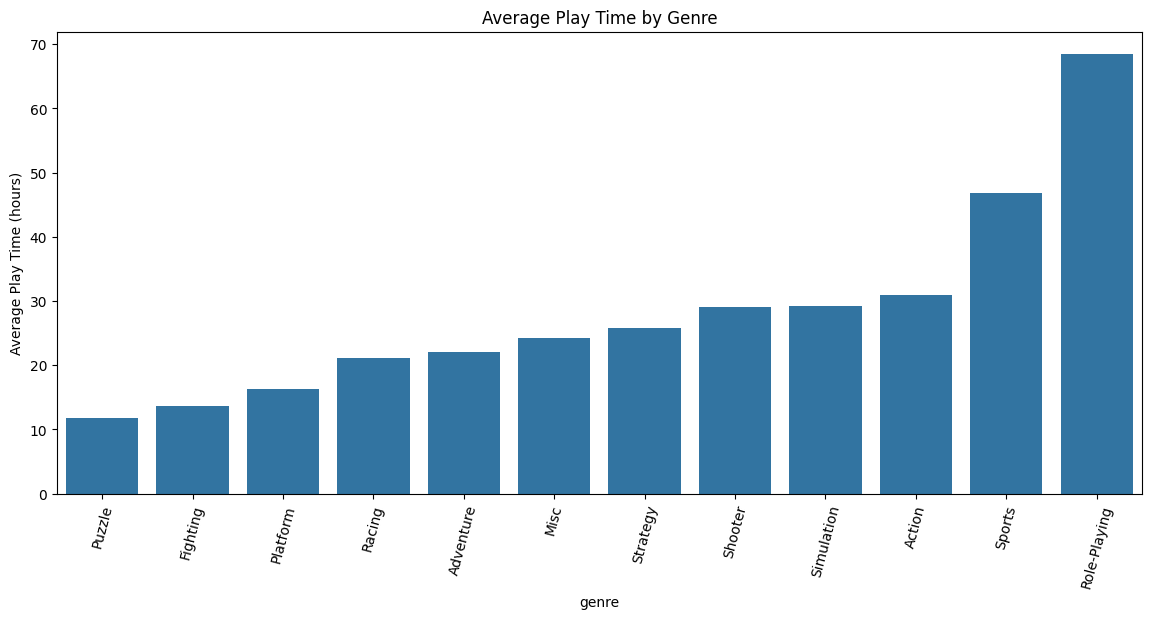

In [18]:
# ------------------------------------------------------------
# Figure 1: Average Play Time by Game Genre (Bar Chart)
# ------------------------------------------------------------
plt.figure(figsize=(14,6))
genre_mean = df.groupby('genre')['playTime'].mean().sort_values()
sns.barplot(x=genre_mean.index, y=genre_mean.values)
plt.xticks(rotation=75)
plt.ylabel("Average Play Time (hours)")
plt.title("Average Play Time by Genre")
plt.show()

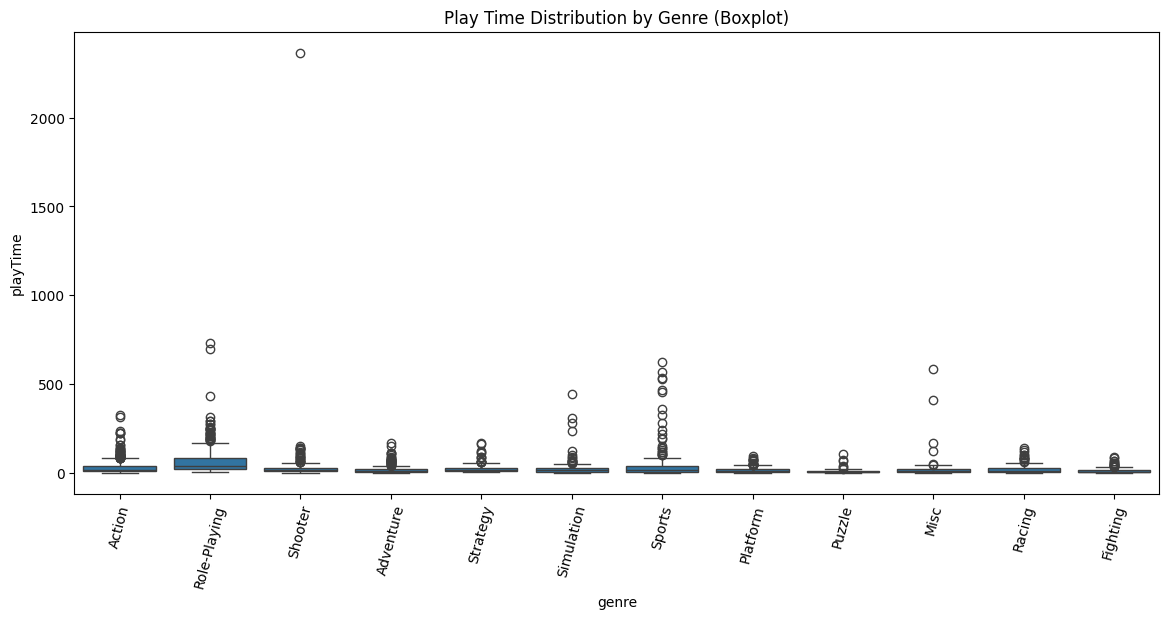

In [19]:
# -----------------------------
# Figure 2: Play Time Distribution Across Genres (Box Plot)
# -----------------------------
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="genre", y="playTime")
plt.xticks(rotation=75)
plt.title("Play Time Distribution by Genre (Boxplot)")
plt.show()

 **Question 1 Answer:**

*Figure 1. Significant differences in average playtime across game genres*

- **RPG (Role-Playing)**: Longest average playtime, exceeding 70 hours  
- **Sports**: Also relatively long, around 47 hours  
- **Action / Shooter / Simulation**: Mid-range, approximately 25–30 hours  
- **Puzzle / Fighting**: Shortest playtime, generally only 10–15 hours  

This shows that there are clear differences in average playtime across different game genres.

## ---

*Figure 2. RPG and Sports exhibit the widest playtime variability (box plot)*

- **RPG** has the largest spread, ranging from short titles to extremely long ones over 100 hours  
- **Sports** also shows notable variability, with many long-playtime titles  
- **Puzzle / Fighting** genres have more concentrated distributions with smaller variability  

This suggests that:

RPG and Sports games tend to be designed with large content volume, complex systems, or repeatable gameplay;  
Puzzle and Fighting games are usually short, fast-paced, and built around quick gameplay loops.

## ---

*3. Overall Conclusion*

Combining both the average playtime and the distribution patterns:

- **Genre** is a key factor influencing game playtime  
- Narrative-heavy and content-rich genres (such as RPG) generally have longer playtime  
- Mechanic-focused or level-based genres (such as Puzzle / Fighting) typically have shorter playtime  

**Therefore, based on these findings, game genre has a significant impact on playtime.**


**Task 2:** 

2. **Does game genre affect the review scores given by players?**  


/var/folders/zm/15khml3n0hb3_l0rm7qr556r0000gn/T/ipykernel_76511/4266959741.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_review.index, y=genre_review.values, palette="viridis")


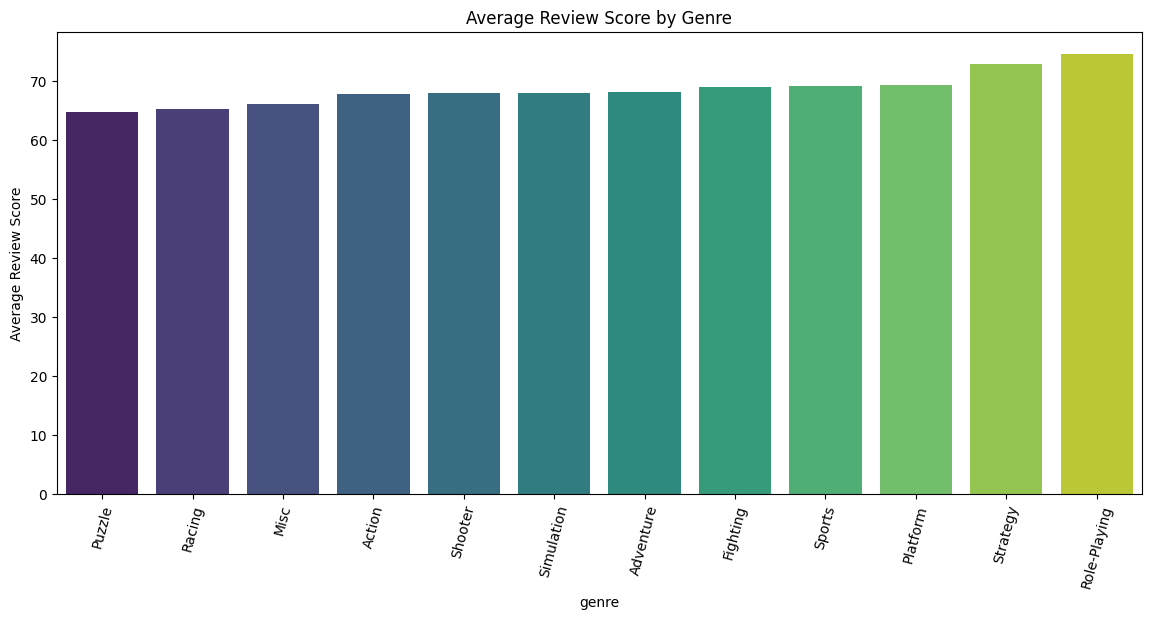

In [20]:
# -----------------------------
# Figure 1: Average Review Score by Genre (Bar Chart)
# -----------------------------
plt.figure(figsize=(14,6))
genre_review = df.groupby('genre')['reviewScore'].mean().sort_values()
sns.barplot(x=genre_review.index, y=genre_review.values, palette="viridis")
plt.xticks(rotation=75)
plt.ylabel("Average Review Score")
plt.title("Average Review Score by Genre")
plt.show()

/var/folders/zm/15khml3n0hb3_l0rm7qr556r0000gn/T/ipykernel_76511/1382831550.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="genre", y="reviewScore", palette="Set2")


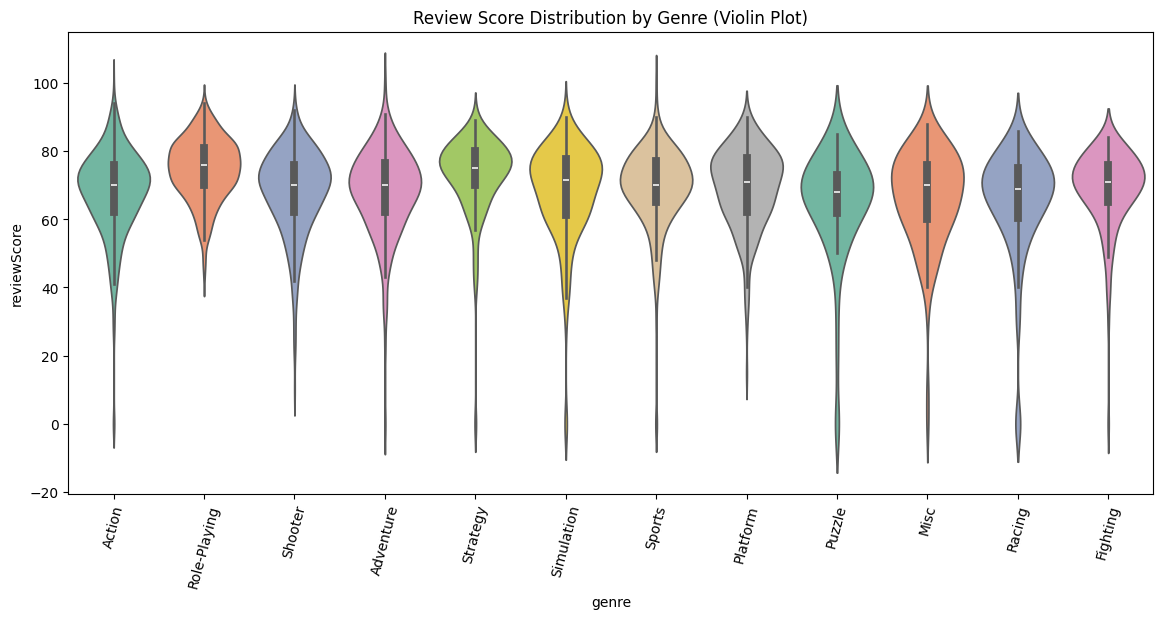

In [21]:
# -----------------------------
# Figure 2: Distribution of Review Scores (Violin Plot)
# -----------------------------
plt.figure(figsize=(14,6))
sns.violinplot(data=df, x="genre", y="reviewScore", palette="Set2")
plt.xticks(rotation=75)
plt.title("Review Score Distribution by Genre (Violin Plot)")
plt.show()

**Question 2 Answer：**

*Figure 1. There are noticeable differences in average review scores across game genres (though less significant than playtime)*

According to the bar chart:

- **Strategy**, **Role-Playing**, and **Platform** genres have the highest average scores, around **72–75**
- **Puzzle**, **Racing**, and **Misc** have the lowest average scores, around **63–66**
- Most genres fall within the **65–72** score range

Overall, there is roughly a 10-point difference between genres, which represents a moderate level of variation.

Game genre does influence review scores, but the effect is weaker compared to its impact on playtime.

# ---

*Figure 2. Most genres show highly overlapping score distributions (violin plot)*

From the violin plot:

- Nearly all genres have scores concentrated between **60–85**
- **Strategy** and **RPG** show a slightly higher proportion of high scores (80+) and higher medians
- **Puzzle / Racing** have more stretched distributions, indicating greater volatility and more low-scoring games
- Most genres share very similar distribution shapes with strong overlap

This indicates that review scores are more influenced by factors such as **game quality, system design, and player expectations**, rather than genre alone.

# ---

*Overall Conclusion*

- Game genre does influence average scores, but the effect is limited  
- **Strategy / RPG** games tend to have higher and more stable scores  
- **Puzzle / Racing** genres show lower and more volatile scores  

Therefore: **genre does affect review scores, but the impact is not very significant.**


**Task 2:**

3. **Is there a correlation between game playtime and review score?**

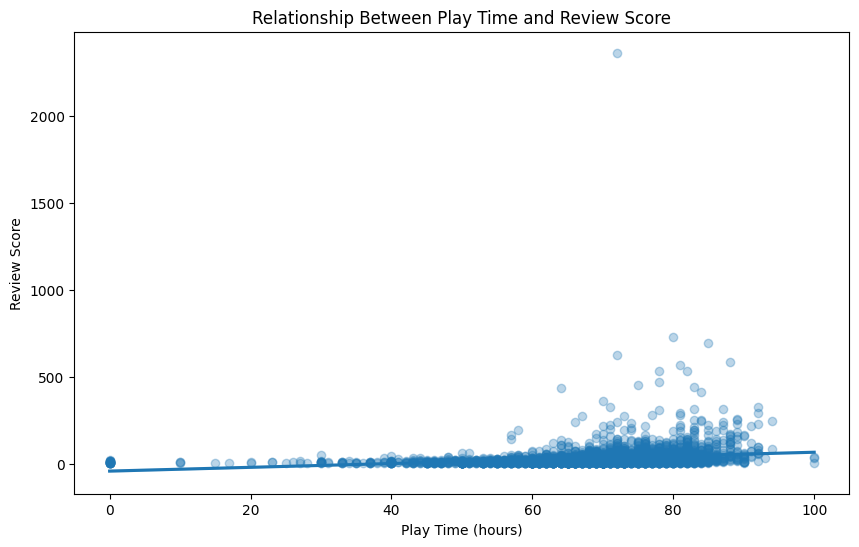

In [22]:
# -----------------------------
# Figure 1: Scatter Plot with Regression Line
# -----------------------------
plt.figure(figsize=(10,6))
sns.regplot(data=df, x="reviewScore", y="playTime", 
            scatter_kws={'alpha':0.3})
plt.xlabel("Play Time (hours)")
plt.ylabel("Review Score")
plt.title("Relationship Between Play Time and Review Score")
plt.show()

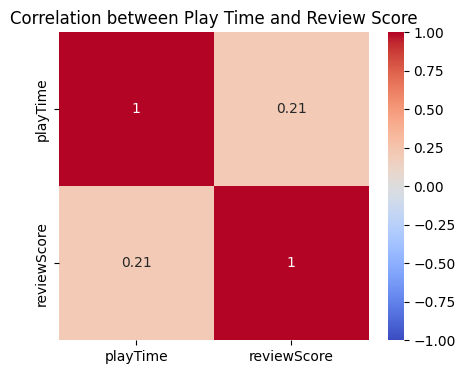

In [23]:
# -----------------------------
# Figure 2: Correlation Heatmap
# -----------------------------
plt.figure(figsize=(5,4))
sns.heatmap(df[['playTime','reviewScore']].corr(), 
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between Play Time and Review Score")
plt.show()

**Question 3 Answer:**

*Figure 1. Relationship between playtime and review score (Scatter Plot + Regression Line)*

- The overall trend is extremely weak, and the points are distributed almost horizontally  
- Most games fall within the **50–90** score range, showing no clear relationship with playtime  
- Even for long-playtime games (60–100 hours), the scores still spread widely (60–90)

This shows that **longer playtime ≠ higher score**.  
Playtime has a very weak influence on review scores and cannot be used to predict them.

# ---

*Figure 2. Correlation heatmap between playtime and review score*

- The correlation coefficient is approximately **0.21** (weak positive correlation)  
- The correlation is negligible and not meaningful for explanation  
- The linear relationship is very weak: increasing playtime results in only a tiny upward trend in score

Therefore, there is almost **no linear relationship** between playtime and review score.

# ---

*Overall Conclusion:*

- Based on both the scatter plot and correlation analysis:  
- **Playtime is not a significant predictor of review scores**  
- The correlation between the two is very weak (0.21)  
- High scores do not require long playtime — short but well-designed games can also receive excellent ratings  

Therefore, **there is no significant correlation between playtime and review score**.


# --------------------------------------------------
### Task 3

# --------------------------------------------------
#### **Limitations & Web Scraping Solution**

After merging the **VGSales** and **HLTB** datasets, we obtained information such as  
**playtime, review score, genre, and platform**.

However, we still lack one crucial dimension needed to answer:

#### **Q4: Does the actual sentiment of player reviews align with the game’s review score?**

# ---

#### **Why the existing data cannot answer this question (Limitations)**

#### 🔹 **1. Review scores are only numerical values, without review text**
- The dataset only contains a numeric score, such as 68, 74, 80  
- It does not reveal *why* players gave this score  
- It cannot reflect what players care about (story? combat? graphics? bugs?)

# ---

#### 🔹 **2. No sentiment information**
- No labels of “positive / negative feedback”  
- We cannot determine whether highly rated games truly receive positive emotional responses

# ---

#### 🔹 **3. Impossible to analyze keywords and their influence**

We cannot extract:
- **Positive terms:** excellent, fun, immersive, great story  
- **Negative terms:** boring, buggy, repetitive, bad AI  

Without review text, it is impossible to build a  
**score ↔ review content** relationship model.

# ---

#### 🧩 **Conclusion: Why do we need Web Scraping?**

Because **without review text, we cannot evaluate whether player sentiment truly matches the review score**.  
Therefore, to answer Q4, we must obtain additional review content from external sources.

# ---

#### **⭐ Web Scraping Solution**

To address this missing dimension, we implemented a Python-based web scraper to collect player review text for each game.

Goal: **Collect around 100 real reviews per game (a sufficient sample for sentiment analysis)**

# ---

#### 📌 **Why Web Scraping Is Important**

With scraped review text, we are able to perform:
- 🔍 **Sentiment Analysis**  
- 🔍 **Keyword Extraction**  
- 🔍 **Evaluation of whether score and sentiment align**

# --------------------------------------------------


#### Required Install Commands for NLP & Web Scraping

To ensure all required packages are available in the environment, install the following:

```bash
pip install requests
pip install nltk
pip install wordcloud
pip install matplotlib

In [7]:
## load needed packages
import requests
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from collections import Counter
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /Users/leo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

- Search Steam AppID by Game Name

In [8]:
## Search Steam for the game by name and return its Steam AppID (unique identifier)
def search_steam_appid(game_name):

    url = f"https://steamcommunity.com/actions/SearchApps/{game_name}"
    try:
        resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        data = resp.json()

        if len(data) == 0:
            return None  

        # 返回最匹配的一项
        return data[0].get("appid", None)

    except Exception as e:
        print("Error:", e)
        return None

# df["appID"] = df["gameName"].apply(search_steam_appid)     
# df.head()  

- Fetch Steam Reviews Using AppID (Steam Official API)

In [9]:
## Fetch the latest English reviews from Steam's official appreviews API,
## using a given Steam AppID, and return them as a clean DataFrame.

def fetch_steam_reviews(appid, num=100):

    url = f"https://store.steampowered.com/appreviews/{appid}"
    
    params = {  
        "json": 1,
        "language": "english",
        "filter": "recent",
        "num_per_page": num,
        "cursor": "*"
    }

    resp = requests.get(url, params=params, headers={"User-Agent": "Mozilla/5.0"})
    data = resp.json()
    
    reviews = data.get("reviews", [])
    rows = []
    for r in reviews[:num]:
        rows.append({
            "appid": appid,
            "recommend": r.get("voted_up"),
            "review_text": r.get("review"),
        })
    return pd.DataFrame(rows)

- Search Steam AppID by Game Name & Fetch Reviews (Integrated Function)

In [10]:
## This function combines two steps:
##    1) Search Steam AppID using the game name
##    2) Fetch reviews using the AppID (from our previous API function)
## 
## In other words:
##    You type a game name → It automatically finds its AppID → 
##    Then downloads the latest `num` reviews and returns them in a DataFrame.
## 
## This is the MOST important integration function in Task 3.

def fetch_reviews_by_name(game_name, num=100):
    appid = search_steam_appid(game_name)

    if appid is None:
        print(f"❌ Unable to find {game_name} 的 AppID")
        return pd.DataFrame()

    print(f"Found the game：{game_name} → AppID = {appid}")

    return fetch_steam_reviews(appid, num=num)

comments_df = fetch_reviews_by_name("Grand Theft Auto IV", 100)
comments_df

Found the game：Grand Theft Auto IV → AppID = 3240220


,appid,recommend,review_text
0,3240220,True,best\r\n\
1,3240220,True,Fun W/ friends\r\n\r\n
2,3240220,True,vnice i recemended all of you qulity is so fun...
3,3240220,True,h
4,3240220,True,good
...,...,...,...
95,3240220,False,Bro this game is like… fine? I guess? Everyone...
96,3240220,True,It's fun as long as you are playing in a priva...
97,3240220,True,amazing
98,3240220,True,good


- Sentiment Analysis using VADER (Classify Each Review as Positive / Negative / Neutral)

In [49]:
## Use VADER (a rule-based sentiment analysis tool) to compute sentiment scores 
## for each review, and classify them into “positive”, “negative”, or “neutral”.


# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_score_vader(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
     # 'compound' ranges from [-1, 1], higher = more positive
    return sia.polarity_scores(text)['compound']

def label_sentiment(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return "positive"
    elif score <= neg_th:
        return "negative"
    else:
        return "neutral"


comments_df["sentiment_score"] = comments_df["review_text"].apply(get_sentiment_score_vader)
comments_df["sentiment_label"] = comments_df["sentiment_score"].apply(label_sentiment)
comments_df.head()


,appid,recommend,review_text,sentiment_score,sentiment_label
0,3240220,True,best\r\n\,0.6369,positive
1,3240220,True,Fun W/ friends\r\n\r\n,0.7506,positive
2,3240220,True,vnice i recemended all of you qulity is so fun...,0.0000,neutral
3,3240220,True,h,0.0000,neutral
4,3240220,True,good,0.4404,positive


- Summarize Sentiment Results (Count, Percentage, Avg Score, Recommend Rate)

In [12]:
## Group all reviews by sentiment category (positive / neutral / negative)
## and compute: count, percentage, average sentiment score, and recommend rate.

summary_df = comments_df.groupby("sentiment_label").agg(
    count=("sentiment_label", "size"),
    avg_sentiment=("sentiment_score", "mean"),
    recommend_rate=("recommend", "mean")
).reset_index()

summary_df["percentage"] = (summary_df["count"] / summary_df["count"].sum()).round(4)
summary_df["avg_sentiment"] = summary_df["avg_sentiment"].round(4)
summary_df["recommend_rate"] = summary_df["recommend_rate"].round(4)

summary_df

,sentiment_label,count,avg_sentiment,recommend_rate,percentage
0,negative,16,-0.5299,0.4375,0.16
1,neutral,28,0.0009,0.7857,0.28
2,positive,56,0.5956,0.8750,0.56


- Combine All Positive and Negative Reviews into Two Large Strings

In [13]:
## Join all positive reviews and negative reviews separately
## Convert to strings to avoid type issues before concatenation.
positive_text = " ".join(comments_df[comments_df["sentiment_label"] == "positive"]["review_text"].astype(str))
negative_text = " ".join(comments_df[comments_df["sentiment_label"] == "negative"]["review_text"].astype(str))

- Clean Review Text: Lowercase, Remove Special Characters, Remove Stopwords ((To make the word cloud cleaner and more meaningful))

In [44]:

# Base English stopwords
stop_words = set(stopwords.words("english"))


## Custom stopwords (words you do NOT want to appear in the word clouds)
## These include: common gaming terms + filler words + noise words
custom_stopwords = {
    "game", "games", "play", "played", "playing",   
    "u", "im", "ive", "feel", "even", "ever", "much",
    "many", "still", "feels", "get", "lot", "every",
    "year", "years", "really", "online", "gta", "time",
    "dont", "cant", "enhanced", "youre", "thing", "also",
    "must"                       
}

# Merge
stop_words = stop_words.union(custom_stopwords)

def clean_text(text):
    text = text.lower()  
    text = re.sub(r"[^a-z\s]", "", text) 
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return " ".join(words)


- Clean Positive & Negative Review Text Separately ((lowercasing, removing punctuation, removing stopwords))

In [45]:
positive_clean = clean_text(positive_text) # Clean all positive review text
negative_clean = clean_text(negative_text) # Clean all negative review text

- Generate Word Clouds for Positive/Negative Reviews

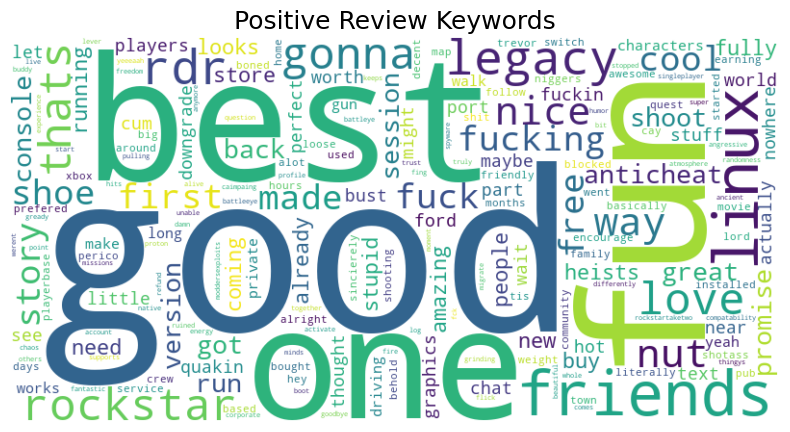

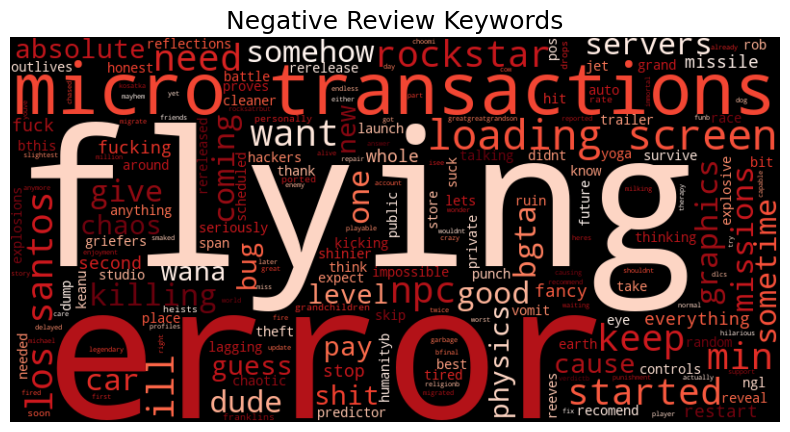

In [46]:
"""
Generate a word cloud for the input text.
Automatically applies different styles for positive vs. negative sentiment.

"""
def generate_wordcloud(text, sentiment="positive"):

    if sentiment.lower() == "positive":
        wc = WordCloud(
            width=800,
            height=400,
            background_color="white"
        ).generate(text)

        title = "Positive Review Keywords"
        title_color = "black"

    else:
        wc = WordCloud(
            width=800,
            height=400,
            background_color="black",
            colormap="Reds"
        ).generate(text)

        title = "Negative Review Keywords"
        title_color = "black"

    # ---- Plot ----
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=18, color=title_color)
    plt.show()


generate_wordcloud(positive_clean, sentiment="positive")
generate_wordcloud(negative_clean, sentiment="negative")

- Top Word Frequency (Positive vs Negative Reviews - top 20)

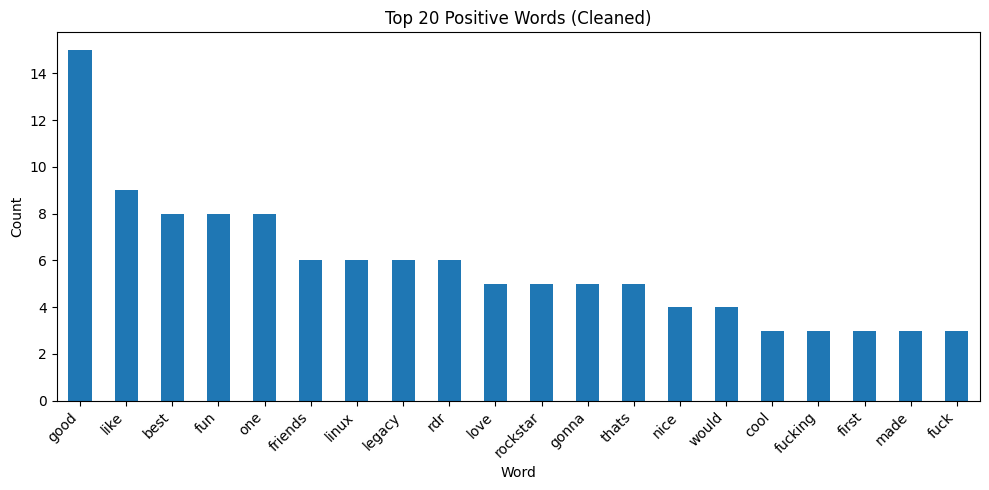

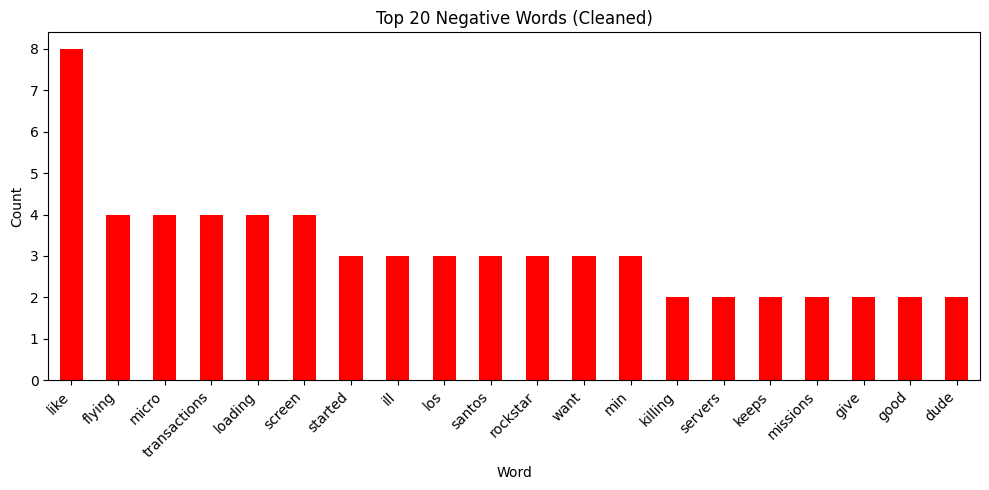

In [47]:

# 1. Prepare stopwords + custom filtering rules
def clean_and_tokenise(text):
    if not text:
        return []
    tokens = []
    for w in text.split():
        w = w.lower().strip(string.punctuation)

        if (w 
            and w not in stop_words
            and not w.isdigit() 
            and len(w) > 2):
            tokens.append(w)
    return tokens

# 2. Clean & tokenize positive/negative review text
pos_tokens = clean_and_tokenise(positive_clean)
neg_tokens = clean_and_tokenise(negative_clean)

# Count top 20 words
pos_words = Counter(pos_tokens).most_common(20)
neg_words = Counter(neg_tokens).most_common(20)



# 3. Plot Top 20 Positive Words
pd.DataFrame(pos_words, columns=["word","count"]).plot(
    kind="bar", x="word", legend=False, figsize=(10,5)
)
plt.title("Top 20 Positive Words (Cleaned)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 4. Plot Top 20 Negative Words
pd.DataFrame(neg_words, columns=["word","count"]).plot(
    kind="bar", x="word", color="red", legend=False, figsize=(10,5)
)
plt.title("Top 20 Negative Words (Cleaned)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
